# Youtube Sentiment Analysis with Amazon Comprehend

Matheus Schmitz<br>
<a href="https://www.linkedin.com/in/matheusschmitz/">LinkedIn</a><br>
<a href="https://matheus-schmitz.github.io/">Github Portfolio</a>

## Installing and Loading Packages

In [1]:
# Python version
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


In [3]:
# https://pypi.org/project/boto3/
!pip install -q boto3

In [4]:
# https://pypi.org/project/spacy/
!pip install -q spacy

In [ ]:
# Instala o dicionário
!python3 -m spacy download en_core_web_lg

In [6]:
# https://pypi.org/project/youtube_dl/
!pip install -q youtube-dl

Installing ffmpeg:

https://stackoverflow.com/questions/30770155/ffprobe-or-avprobe-not-found-please-install-one

In [7]:
# https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2.html
# https://pypi.org/project/awscli/
!pip install -q awscli

## Configurating the AWS Client

Run on terminal: aws configure

Input the values for:
- AWS Access Key ID
- AWS Secret Access Key 
- Default region name
- Default output format

In [8]:
# Imports
import os
import json
import time
import boto3
import spacy
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from botocore.exceptions import ClientError
from datetime import date
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Extracting Audio and Text from Youtube Videos

### Downloading and Preparing Data

Here are 5 famous speeches available on Youtube that will be used:

1- [Martin Luther King Jr., "I Have a Dream"](https://www.youtube.com/watch?v=I47Y6VHc3Ms)<br>

2- [John F. Kennedy, "The Decision to Go to the Moon"](https://www.youtube.com/watch?v=QAmHcdwKgtQ)<br>

3- [Winston Churchill, "We Shall Fight on the Beaches"](https://www.youtube.com/watch?v=s_LncVnecLA)<br>

4- [Ronald Reagan, "Remarks at the Brandenburg Gate"](https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s)<br>

5- [General Douglas MacArthur, "Duty, Honor, Country"](https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s)<br>

In [10]:
# Dictionary with the URL of each video
dict_urls_youtube = {'luther_king': 'https://www.youtube.com/watch?v=I47Y6VHc3Ms',
                     'kennedy': 'https://www.youtube.com/watch?v=QAmHcdwKgtQ',
                     'churchill': 'https://www.youtube.com/watch?v=s_LncVnecLA',
                     'reagan': 'https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s',
                     'macarthur': 'https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s'}

In [11]:
# Download the audio from the video
for url in list(dict_urls_youtube.values()):
    print(f'Fazendo Download do Vídeo: {url}')
    os.system(f'youtube-dl -x --audio-format "mp3" {url}')

Fazendo Download do Vídeo: https://www.youtube.com/watch?v=I47Y6VHc3Ms
Fazendo Download do Vídeo: https://www.youtube.com/watch?v=QAmHcdwKgtQ
Fazendo Download do Vídeo: https://www.youtube.com/watch?v=s_LncVnecLA
Fazendo Download do Vídeo: https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s
Fazendo Download do Vídeo: https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s


In [12]:
# Create a DataFrame
df_audio_videos = pd.DataFrame.from_dict(dict_urls_youtube, orient = 'index', columns = ['youtube_urls'])

In [13]:
# View
df_audio_videos

,youtube_urls
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ
churchill,https://www.youtube.com/watch?v=s_LncVnecLA
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s


In [14]:
# Rename the videos
for arquivo_audio in os.listdir('.'):
    
    if 'churchill' in arquivo_audio.lower():
        os.rename(arquivo_audio, 'churchill.mp3')
        df_audio_videos.at['churchill', 'filename'] = 'churchill.mp3'
    
    elif 'reagan' in arquivo_audio.lower():
        os.rename(arquivo_audio.lower(), 'reagan.mp3')
        df_audio_videos.at['reagan', 'filename'] = 'reagan.mp3'
    
    elif 'king' in arquivo_audio.lower():
        os.rename(arquivo_audio.lower(), 'king.mp3')
        df_audio_videos.at['luther_king', 'filename'] = 'king.mp3'
    
    elif 'macarthur' in arquivo_audio.lower():
        os.rename(arquivo_audio.lower(), 'macarthur.mp3')
        df_audio_videos.at['macarthur', 'filename'] = 'macarthur.mp3'
    
    elif 'kennedy' in arquivo_audio.lower():
        os.rename(arquivo_audio.lower(), 'kennedy.mp3')
        df_audio_videos.at['kennedy', 'filename'] = 'kennedy.mp3'

In [15]:
# View
df_audio_videos

,youtube_urls,filename
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms,king.mp3
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,kennedy.mp3
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,churchill.mp3
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,reagan.mp3
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,macarthur.mp3


### Storing Videos on Amazon S3

In [16]:
# Set my credentials
aws_access_key_id = ''
aws_secret_access_key = ''
region_name = 'us-east-2'

In [17]:
# Create Session
session = boto3.session.Session(aws_access_key_id = aws_access_key_id,
                                aws_secret_access_key = aws_secret_access_key,
                                region_name = region_name)

In [18]:
# Create a connection with S3
s3 = boto3.client('s3')
client_s3 = boto3.client('s3')

In [19]:
# Identify the buckets
response = s3.list_buckets()
buckets = [bucket['Name'] for bucket in response['Buckets']]

In [20]:
# List the buckets
for bucket in buckets:
    print(bucket)

cf-templates-k86kpoh8b52x-us-east-2
design-aws-dsa
design-aws-dsa-log
design-aws-dsa-web
design-aws-dsa-webfiles
dsa-deploy-app
dsa-sistemas-mini-projeto5
sagemaker-studio-879456481532-3juvpt4pbqm
sagemaker-studio-879456481532-du2zpon7mfr
sagemaker-studio-8h3p453lu7q
sagemaker-us-east-2-879456481532
www.designawsdsa.com


In [21]:
# Define the bucket to upload files
bucket_name = 'dsa-sistemas-mini-projeto5'

In [22]:
# Upload the videos
for arquivo_audio in df_audio_videos.filename.values:
    print(arquivo_audio)
    client_s3.upload_file(arquivo_audio, bucket_name,  arquivo_audio)

king.mp3
kennedy.mp3
churchill.mp3
reagan.mp3
macarthur.mp3


In [23]:
# View
df_audio_videos

,youtube_urls,filename
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms,king.mp3
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,kennedy.mp3
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,churchill.mp3
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,reagan.mp3
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,macarthur.mp3


In [24]:
# Define the file URLs on S3
for index, row in df_audio_videos.iterrows():
    
    bucket_location = boto3.client('s3').get_bucket_location(Bucket = bucket_name)
    
    object_uri = f"s3://{bucket_name}/{row['filename']}"
    
    df_audio_videos.at[index, 'uri'] = object_uri
    
    print(object_uri)

s3://dsa-sistemas-mini-projeto5/king.mp3
s3://dsa-sistemas-mini-projeto5/kennedy.mp3
s3://dsa-sistemas-mini-projeto5/churchill.mp3
s3://dsa-sistemas-mini-projeto5/reagan.mp3
s3://dsa-sistemas-mini-projeto5/macarthur.mp3


### Transcribing the Text in the Audio Files with Amazon Transcribe

In [25]:
# View
df_audio_videos

,youtube_urls,filename,uri
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms,king.mp3,s3://dsa-sistemas-mini-projeto5/king.mp3
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,kennedy.mp3,s3://dsa-sistemas-mini-projeto5/kennedy.mp3
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,churchill.mp3,s3://dsa-sistemas-mini-projeto5/churchill.mp3
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,reagan.mp3,s3://dsa-sistemas-mini-projeto5/reagan.mp3
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,macarthur.mp3,s3://dsa-sistemas-mini-projeto5/macarthur.mp3


https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/transcribe.html

https://docs.aws.amazon.com/pt_br/transcribe/latest/dg/API_StartTranscriptionJob.html

https://docs.aws.amazon.com/pt_br/transcribe/latest/dg/API_Media.html

In [26]:
# Function to initialize the Amazon Transcribe job
def transcreve_audio(bucket, job_name, file_uri, wait_process = True):
    
    # Open the client
    client_transcribe = boto3.client('transcribe', region_name = 'us-east-2')
    
    # File URI
    print(file_uri)
    
    # Function to start transcription
    client_transcribe.start_transcription_job(TranscriptionJobName = job_name,
                                              Media = {'MediaFileUri': file_uri},
                                              MediaFormat = 'mp3',
                                              LanguageCode = 'en-US',
                                              OutputBucketName = bucket)
    
    # Conditional to wait the job execution
    if wait_process:
        while True:
            status = client_transcribe.get_transcription_job(TranscriptionJobName = job_name)
            if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
                break
            print("Processamento em Andamento.")
            time.sleep(20)

        print('Transcrição Concluída!')
        return status

In [27]:
# Define the key to use on the transcription job
key = "dsa-mini-projeto5"

In [28]:
# Run the transcription function
for index, row in df_audio_videos.iterrows():    
    
    # Print
    print(f'{index}_speech_{key}')
    print(row.uri)
    
    # Transcribe text from the audio files
    transcreve_audio(bucket_name, f'{index}_speech_{key}', row.uri, wait_process = False)
    
    # Save results to the DataFrame
    df_audio_videos.at[index, 'transcription_url'] = f"https://{bucket_name}.s3.amazonaws.com/{index}_speech_{key}.json"
    df_audio_videos.at[index, 'json_transcription'] = f"{index}_speech_{key}.json"

luther_king_speech_dsa-mini-projeto5
s3://dsa-sistemas-mini-projeto5/king.mp3
s3://dsa-sistemas-mini-projeto5/king.mp3
kennedy_speech_dsa-mini-projeto5
s3://dsa-sistemas-mini-projeto5/kennedy.mp3
s3://dsa-sistemas-mini-projeto5/kennedy.mp3
churchill_speech_dsa-mini-projeto5
s3://dsa-sistemas-mini-projeto5/churchill.mp3
s3://dsa-sistemas-mini-projeto5/churchill.mp3
reagan_speech_dsa-mini-projeto5
s3://dsa-sistemas-mini-projeto5/reagan.mp3
s3://dsa-sistemas-mini-projeto5/reagan.mp3
macarthur_speech_dsa-mini-projeto5
s3://dsa-sistemas-mini-projeto5/macarthur.mp3
s3://dsa-sistemas-mini-projeto5/macarthur.mp3


In [29]:
# View
df_audio_videos

,youtube_urls,filename,uri,transcription_url,json_transcription
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms,king.mp3,s3://dsa-sistemas-mini-projeto5/king.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,luther_king_speech_dsa-mini-projeto5.json
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,kennedy.mp3,s3://dsa-sistemas-mini-projeto5/kennedy.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,kennedy_speech_dsa-mini-projeto5.json
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,churchill.mp3,s3://dsa-sistemas-mini-projeto5/churchill.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,churchill_speech_dsa-mini-projeto5.json
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,reagan.mp3,s3://dsa-sistemas-mini-projeto5/reagan.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,reagan_speech_dsa-mini-projeto5.json
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,macarthur.mp3,s3://dsa-sistemas-mini-projeto5/macarthur.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,macarthur_speech_dsa-mini-projeto5.json


In [30]:
# Check the Amazon Transcribe jobs with COMPLETED status
client_transcribe = boto3.client('transcribe', region_name = 'us-east-2')
resposta = client_transcribe.list_transcription_jobs(Status = 'COMPLETED')
resposta

{'Status': 'COMPLETED',
 'TranscriptionJobSummaries': [{'TranscriptionJobName': 'macarthur_speech_dsa-mini-projeto5',
   'CreationTime': datetime.datetime(2021, 4, 17, 17, 12, 5, 470000, tzinfo=tzlocal()),
   'StartTime': datetime.datetime(2021, 4, 17, 17, 12, 5, 494000, tzinfo=tzlocal()),
   'CompletionTime': datetime.datetime(2021, 4, 17, 17, 17, 6, 318000, tzinfo=tzlocal()),
   'LanguageCode': 'en-US',
   'TranscriptionJobStatus': 'COMPLETED',
   'OutputLocationType': 'CUSTOMER_BUCKET'},
  {'TranscriptionJobName': 'reagan_speech_dsa-mini-projeto5',
   'CreationTime': datetime.datetime(2021, 4, 17, 17, 12, 4, 880000, tzinfo=tzlocal()),
   'StartTime': datetime.datetime(2021, 4, 17, 17, 12, 4, 899000, tzinfo=tzlocal()),
   'CompletionTime': datetime.datetime(2021, 4, 17, 17, 15, 39, 965000, tzinfo=tzlocal()),
   'LanguageCode': 'en-US',
   'TranscriptionJobStatus': 'COMPLETED',
   'OutputLocationType': 'CUSTOMER_BUCKET'},
  {'TranscriptionJobName': 'churchill_speech_dsa-mini-projeto5'

## Comparing the Amazon Comprehend Transcription with the SpaCy Transcription

To verify the quality of the transcription generated with Amazon Transcribe, comparing it with the transcription obtained from SpaCy.

In [31]:
# Function to get the text from the JSOn file generated by Amazon Transcribe
def get_texto(bucket, key):
    
    # Connect to S3
    s3 = boto3.client('s3', region_name = 'us-east-2')
    
    # Generate the object with the bucket connection
    object = s3.get_object(Bucket = bucket, Key = key)
    
    # Serialize the object
    serializedObject = object['Body'].read()
    
    # Load the JSON data
    data = json.loads(serializedObject)
    
    # Return the transcription
    return data.get('results').get('transcripts')[0].get('transcript')

In [32]:
# Read the original transcription from the JSON file
with open('dados/transcripts_originais.json', 'r') as f:
    original_transcriptions = json.load(f)

In [33]:
# View
original_transcriptions

{'churchill': 'When, a week ago today, I asked the House to fix this afternoon as the occasion for a statement, I feared it would be my hard lot to announce the greatest military disaster in our long history. I thought-and some good judges agreed with me-that perhaps 20,000 or 30,000 men might be re-embarked. But it certainly seemed that the whole of the French First Army and the whole of the British Expeditionary Force north of the Amiens-Abbeville gap would be broken up in the open field or else would have to capitulate for lack of food and ammunition. These were the hard and heavy tidings for which I called upon the House and the nation to prepare themselves a week ago. The whole root and core and brain of the British Army, on which and around which we were to build, and are to build, the great British Armies in the later years of the war, seemed about to perish upon the field or to be led into an ignominious and starving captivity.The enemy attacked on all sides with great strength

In [34]:
# Function to process the text
def processa_texto(text):
    
    # Convert to lower case
    doc = nlp(text.lower())
    
    # List to store result
    result = []
    
    # Loop
    for token in doc:
        if token.text in nlp.Defaults.stop_words:
            continue
        if token.is_punct:
            continue
        if token.lemma_ == '-PRON-':
            continue
        result.append(token.lemma_)
    return " ".join(result)

In [35]:
# View
df_audio_videos

,youtube_urls,filename,uri,transcription_url,json_transcription
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms,king.mp3,s3://dsa-sistemas-mini-projeto5/king.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,luther_king_speech_dsa-mini-projeto5.json
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,kennedy.mp3,s3://dsa-sistemas-mini-projeto5/kennedy.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,kennedy_speech_dsa-mini-projeto5.json
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,churchill.mp3,s3://dsa-sistemas-mini-projeto5/churchill.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,churchill_speech_dsa-mini-projeto5.json
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,reagan.mp3,s3://dsa-sistemas-mini-projeto5/reagan.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,reagan_speech_dsa-mini-projeto5.json
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,macarthur.mp3,s3://dsa-sistemas-mini-projeto5/macarthur.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,macarthur_speech_dsa-mini-projeto5.json


In [36]:
# Iterate through the speeches and compare the transcriptions of Amazon vs SpaCy
for index, row in df_audio_videos.iterrows():
    
    print(index, row)
    
    # Load the dictionary
    nlp = spacy.load('en_core_web_lg') 
    
    # Process the original transcription text
    original_transcription = nlp(processa_texto(original_transcriptions.get(index)))
    
    # Process the text from Amazon Transcribe
    transcribe_transcription = nlp(processa_texto(get_texto(bucket_name, row.json_transcription)))
    
    # Calculate similarity
    similaridade = original_transcription.similarity(transcribe_transcription)
    
    # Save result to a DataFrame
    df_audio_videos.at[index, 'similaridade'] = similaridade
    
    print(f'\nSimilaridade Word2vec para o discurso de {index}: {similaridade}')   

luther_king youtube_urls                https://www.youtube.com/watch?v=I47Y6VHc3Ms
filename                                                       king.mp3
uri                            s3://dsa-sistemas-mini-projeto5/king.mp3
transcription_url     https://dsa-sistemas-mini-projeto5.s3.amazonaw...
json_transcription            luther_king_speech_dsa-mini-projeto5.json
Name: luther_king, dtype: object

Similaridade Word2vec para o discurso de luther_king: 0.9980868560317497
kennedy youtube_urls                https://www.youtube.com/watch?v=QAmHcdwKgtQ
filename                                                    kennedy.mp3
uri                         s3://dsa-sistemas-mini-projeto5/kennedy.mp3
transcription_url     https://dsa-sistemas-mini-projeto5.s3.amazonaw...
json_transcription                kennedy_speech_dsa-mini-projeto5.json
Name: kennedy, dtype: object

Similaridade Word2vec para o discurso de kennedy: 0.9995996536888027
churchill youtube_urls                https://www.yout

In [37]:
# Label values
y_labels = [label.replace('_', ' ').capitalize() for label in df_audio_videos.index]
print(y_labels)

['Luther king', 'Kennedy', 'Churchill', 'Reagan', 'Macarthur']


In [38]:
# Ser similarity values to percentage
x_values = [x * 100 for x in df_audio_videos.similaridade ]
print(x_values)

[99.80868560317498, 99.95996536888026, 99.75913181060135, 99.94992064962662, 99.90477621523232]


In [39]:
# Save to DataFrame
df_audio_videos['label'], df_audio_videos['similaridade_percentual'] = y_labels, x_values

In [40]:
# View
df_audio_videos

,youtube_urls,filename,uri,transcription_url,json_transcription,similaridade,label,similaridade_percentual
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms,king.mp3,s3://dsa-sistemas-mini-projeto5/king.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,luther_king_speech_dsa-mini-projeto5.json,0.998087,Luther king,99.808686
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,kennedy.mp3,s3://dsa-sistemas-mini-projeto5/kennedy.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,kennedy_speech_dsa-mini-projeto5.json,0.999600,Kennedy,99.959965
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,churchill.mp3,s3://dsa-sistemas-mini-projeto5/churchill.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,churchill_speech_dsa-mini-projeto5.json,0.997591,Churchill,99.759132
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,reagan.mp3,s3://dsa-sistemas-mini-projeto5/reagan.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,reagan_speech_dsa-mini-projeto5.json,0.999499,Reagan,99.949921
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,macarthur.mp3,s3://dsa-sistemas-mini-projeto5/macarthur.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,macarthur_speech_dsa-mini-projeto5.json,0.999048,Macarthur,99.904776


## Topic Modeling and Named Entity Recognition

In [41]:
# Topic modeling
for index, row in df_audio_videos.iterrows():
    
    print(f"Renderizando o texto de {index}")    
    
    # Load the dictionary
    nlp = spacy.load('en_core_web_lg')
    
    # SpaCy transcription
    original_transcription = nlp(original_transcriptions.get(index))    
    
    # Amazon Transcribe transcription
    transcribe_transcription = nlp(get_texto(bucket_name, row.json_transcription))
    
    # Render 
    svg_original = spacy.displacy.render(original_transcription, style = "ent", jupyter = False)
    svg_transcribe = spacy.displacy.render(transcribe_transcription, style = "ent", jupyter = False)
    
    # Grava em disco
    with open(f'dados/{index}_original.html', 'w',  encoding = "utf-8") as page:
        page.write(svg_original)
    with open(f'dados/{index}_transcribe.html', 'w',  encoding = "utf-8") as page:
        page.write(svg_transcribe)

Renderizando o texto de luther_king
Renderizando o texto de kennedy
Renderizando o texto de churchill
Renderizando o texto de reagan
Renderizando o texto de macarthur


## Sentiment Analysis with Amazon Comprehend

In [42]:
# Function to analyze sentiment with Amazon Comprehend
def analisa_sentimento(text):
    
    # List
    list_parts = []
    
    # Text for analysis
    text_for_analysis = ''
    
    # Loop through sentences
    for sentence in text.split('.'):
        current_text = text_for_analysis + f'{sentence}.'

        if len(current_text.encode('utf-8')) > 5000:
            list_parts.append([len(text_for_analysis), text_for_analysis])
            text_for_analysis = f'{sentence}.'
        else:
            text_for_analysis += f'{sentence}.'

    # Append
    list_parts.append([len(text_for_analysis), text_for_analysis])
    
    # Dictionary
    dict_comprehend = {}
    
    # Loop
    for t_parts in list_parts:
        
        # Connect to Amazon Comprehend
        comprehend_client = boto3.client(service_name = 'comprehend', region_name = 'us-east-2')
        
        # Detect sentiment on the text
        sentimentData = comprehend_client.detect_sentiment(Text = t_parts[1], LanguageCode = 'en')
        
        # Add to dictionary
        dict_comprehend[t_parts[0]] = sentimentData
        dict_comprehend[t_parts[0]]['ratio'] = t_parts[0]/float(len(text))

    final_dict = {'Positive':0, 'Negative':0, 'Neutral':0, 'Mixed':0}
    list_sentiments = ['Positive', 'Negative', 'Neutral', 'Mixed']
    
    for sentiment in list_sentiments:
        for key, value in dict_comprehend.items():
            final_dict[sentiment] += value.get('SentimentScore').get(sentiment) * value.get('ratio')
    
    return final_dict

In [43]:
# Run the sentiment analysis
for index, row in df_audio_videos.iterrows():
    
    # Obtain the text from Amazon Transcribe
    transcript_text = get_texto(bucket_name, row.json_transcription)
    
    # Run the sentiment analysis
    comprehend_results = analisa_sentimento(transcript_text)
    
    # Add the result to the DataFrame
    for k,v in comprehend_results.items():
        df_audio_videos.at[index, k] = v    

In [44]:
# Round the values to percentages
df_audio_videos = df_audio_videos.round(2)

In [45]:
# View
df_audio_videos

,youtube_urls,filename,uri,transcription_url,json_transcription,similaridade,label,similaridade_percentual,Positive,Negative,Neutral,Mixed
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms,king.mp3,s3://dsa-sistemas-mini-projeto5/king.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,luther_king_speech_dsa-mini-projeto5.json,1.0,Luther king,99.81,0.54,0.17,0.15,0.13
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,kennedy.mp3,s3://dsa-sistemas-mini-projeto5/kennedy.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,kennedy_speech_dsa-mini-projeto5.json,1.0,Kennedy,99.96,0.46,0.03,0.18,0.33
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,churchill.mp3,s3://dsa-sistemas-mini-projeto5/churchill.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,churchill_speech_dsa-mini-projeto5.json,1.0,Churchill,99.76,0.10,0.25,0.51,0.15
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,reagan.mp3,s3://dsa-sistemas-mini-projeto5/reagan.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,reagan_speech_dsa-mini-projeto5.json,1.0,Reagan,99.95,0.43,0.06,0.28,0.23
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,macarthur.mp3,s3://dsa-sistemas-mini-projeto5/macarthur.mp3,https://dsa-sistemas-mini-projeto5.s3.amazonaw...,macarthur_speech_dsa-mini-projeto5.json,1.0,Macarthur,99.90,0.65,0.02,0.26,0.07


### Visualize the Results from Sentiment Analysis

In [46]:
# DataFrame with labels and detected sentiments
df_sentimento = df_audio_videos[['label', 'Positive', 'Negative', 'Neutral', 'Mixed']]

In [47]:
# View
df_sentimento

,label,Positive,Negative,Neutral,Mixed
luther_king,Luther king,0.54,0.17,0.15,0.13
kennedy,Kennedy,0.46,0.03,0.18,0.33
churchill,Churchill,0.10,0.25,0.51,0.15
reagan,Reagan,0.43,0.06,0.28,0.23
macarthur,Macarthur,0.65,0.02,0.26,0.07


In [48]:
# Melt the DataFrame to simplify visualization
df_sentimento_melt = pd.melt(df_sentimento, id_vars = "label", var_name = "sentimento", value_name = "sentiment_rate")

In [49]:
# View
df_sentimento_melt

,label,sentimento,sentiment_rate
0,Luther king,Positive,0.54
1,Kennedy,Positive,0.46
2,Churchill,Positive,0.10
3,Reagan,Positive,0.43
4,Macarthur,Positive,0.65
5,Luther king,Negative,0.17
6,Kennedy,Negative,0.03
7,Churchill,Negative,0.25
8,Reagan,Negative,0.06
9,Macarthur,Negative,0.02


In [50]:
# Adjust percentages
df_sentimento_melt['sentiment_percentage'] = df_sentimento_melt.sentiment_rate * 100

In [51]:
# View
df_sentimento_melt

,label,sentimento,sentiment_rate,sentiment_percentage
0,Luther king,Positive,0.54,54.0
1,Kennedy,Positive,0.46,46.0
2,Churchill,Positive,0.10,10.0
3,Reagan,Positive,0.43,43.0
4,Macarthur,Positive,0.65,65.0
5,Luther king,Negative,0.17,17.0
6,Kennedy,Negative,0.03,3.0
7,Churchill,Negative,0.25,25.0
8,Reagan,Negative,0.06,6.0
9,Macarthur,Negative,0.02,2.0


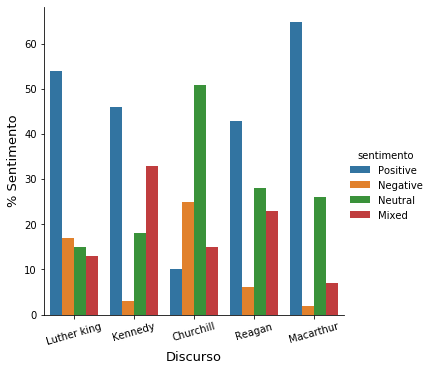

In [53]:
# Plot
sns_plot = sns.factorplot(x = 'label', 
                          y = 'sentiment_percentage', 
                          hue = 'sentimento', 
                          data = df_sentimento_melt, 
                          kind = 'bar')
sns_plot.set_xticklabels(rotation = 16)
sns_plot.set_xlabels('Discurso', fontsize = 13)
sns_plot.set_ylabels('% Sentimento', fontsize = 13)
sns_plot.set_titles('Análise de Sentimento')
sns_plot.savefig("imagens/analise.png", orientation = 'landscape', bbox_inches = 'tight')

In [54]:
# Reindex by sentiment
df_sentimento_reindexado = df_sentimento.drop('label', axis = 1).T
df_sentimento_reindexado = df_sentimento_reindexado.reindex(index = ['Positive', 'Negative', 'Neutral', 'Mixed'])

In [55]:
# View
df_sentimento_reindexado

,luther_king,kennedy,churchill,reagan,macarthur
Positive,0.54,0.46,0.10,0.43,0.65
Negative,0.17,0.03,0.25,0.06,0.02
Neutral,0.15,0.18,0.51,0.28,0.26
Mixed,0.13,0.33,0.15,0.23,0.07


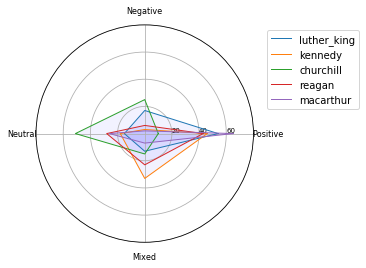

In [59]:
# Radar Plot

# Categories
categories = ['Positive', 'Negative', 'Neutral', 'Mixed']
colors = ['']
N = len(categories)
legend = []

# Loop
for n in range(len(df_sentimento_reindexado.columns)):
    
    # Values
    values = df_sentimento_reindexado[df_sentimento_reindexado.columns[n]].tolist()
    values += values[:1]
    legend.append(df_sentimento_reindexado.columns[n])

    # Angles
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Subplot
    ax = plt.subplot(111, polar = True)
    plt.xticks(angles[:-1], categories, color = 'black', size = 8)

    # Labels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6, 0.8], ["20", "40", "60", ""], color = "black", size = 7)
    plt.ylim(0,0.80)
    ax.plot(angles, values, linewidth = 1, linestyle = 'solid')
    
    # legend
    plt.legend(legend, bbox_to_anchor = (1.04,1), loc = "upper left")

    # Fill
    ax.fill(angles, values, 'b', alpha = 0.05)

plt.savefig(f'imagens/radar_plot.png', orientation = 'landscape', bbox_inches = 'tight')
plt.show()

# End

Matheus Schmitz<br>
<a href="https://www.linkedin.com/in/matheusschmitz/">LinkedIn</a><br>
<a href="https://matheus-schmitz.github.io/">Github Portfolio</a>